In [1]:
batch_size = 4000
lr = 0.002
num_epoch = 500
number_of_features = 41
number_of_class_attack_cat = 11
number_of_class_label = 2
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path1,data_set_path2):
        df1 = pd.read_csv(data_set_path1)

        # preprocceing
        df1.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['proto' ,'state']
        df1[cols] = df1[cols].apply(LabelEncoder().fit_transform)
        #----------------------
        df2 = pd.read_csv(data_set_path2)
        
        # preprocceing
        df2.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df2[cols] = df2[cols].apply(LabelEncoder().fit_transform)

        df_all_rows = pd.concat([df1, df2])

        print(df_all_rows.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df_all_rows['attack_cat'].value_counts())

        self.data_array = df_all_rows.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path1,data_set_path2):
        df1 = pd.read_csv(data_set_path1)

        # preprocceing
        df1.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)        
        cols = ['proto' ,'state']
        df1[cols] = df1[cols].apply(LabelEncoder().fit_transform)
        #----------------------
        df2 = pd.read_csv(data_set_path2)
        
        # preprocceing
        df2.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)        
        cols = ['proto' ,'state']
        df2[cols] = df2[cols].apply(LabelEncoder().fit_transform)

        df_all_rows = pd.concat([df1, df2])

        print(df_all_rows.label.value_counts().sort_values().plot(kind = "pie"))
        print(df_all_rows['label'].value_counts())

        self.data_array = df_all_rows.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

AxesSubplot(0.125,0.125;0.775x0.755)
6     93000
5     58871
3     44525
4     24246
10    16353
2     16353
7     13987
0      2677
1      2329
8      1511
9       174
Name: attack_cat, dtype: int64


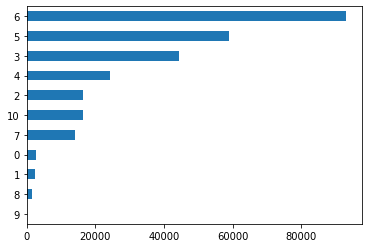

In [5]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/dos_fake.csv",
                                                 "/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

AxesSubplot(0.260833,0.125;0.503333x0.755)
1    181026
0     93000
Name: label, dtype: int64


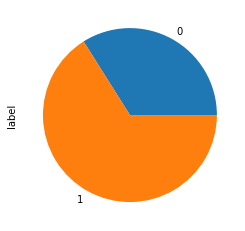

In [6]:
dataset_label = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/dos_fake.csv",
                                                           "/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

# **preprocessing ended**

# **create model**

In [8]:
class Model_Attack_Cat(nn.Module):

    def __init__(self):
        super(Model_Attack_Cat, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_attack_cat)
        )

    def forward(self,x):
        return self.layers(x)

class Model_Label(nn.Module):

    def __init__(self):
        super(Model_Label, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_label)
        )
      

    def forward(self,x):
         return self.layers(x)

In [9]:
my_model_attack = Model_Attack_Cat().to(device=device)
my_model_attack

Model_Attack_Cat(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=11, bias=True)
  )
)

In [10]:
my_model_label = Model_Label().to(device=device)
my_model_label

Model_Label(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)

# **optimizer and loss function**

In [11]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=lr)
optimizer2 = opt.Adam(params=my_model_label.parameters(),lr=lr)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

loss : 1.7203
loss : 0.4497
loss : 0.4263
loss : 0.4081
loss : 0.4054
loss : 0.4110
loss : 0.4195
loss : 0.3721
loss : 0.3943
loss : 0.3767
loss : 0.3671
Execution Time : 1100075.3750


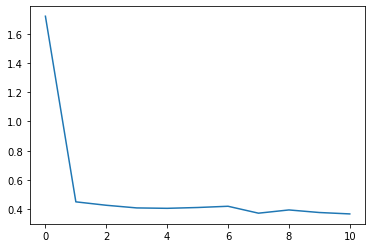

In [13]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x),batch_y)
        loss1.backward()
        optimizer1.step()

    if epoch % 50 == 0:
        print("loss : %.4f" % (loss1.item()))
        loss_plot.append(loss1.item())

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test attack cat**

In [14]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)


print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

acc : 83.19%


Confusion matrix, without normalization
[[ 4842     3     0     0     0     1     0     0     2     0     0]
 [    0     5     1     0     2     2     1    44     2     0     0]
 [    0     0   254    33    33    11    46    66     9     0     0]
 [    0     0     9  3203    32     5    12   880    19     4     0]
 [    0     0    42    29 25461     9  2115   232    27     2    12]
 [    2     0     8     1    12 17402    30   237    47     1     1]
 [    1     1    29    41  1731    13  4602   782    18     3     2]
 [    4     1    61   238   241    74   435 12142   202     6     5]
 [    0     0    56    26    54    21   148  4197   373     8     6]
 [    0     0     4     8     3     2    95   513     6    43     0]
 [    0     0     0     1   114     0    92   540    11     0    63]]


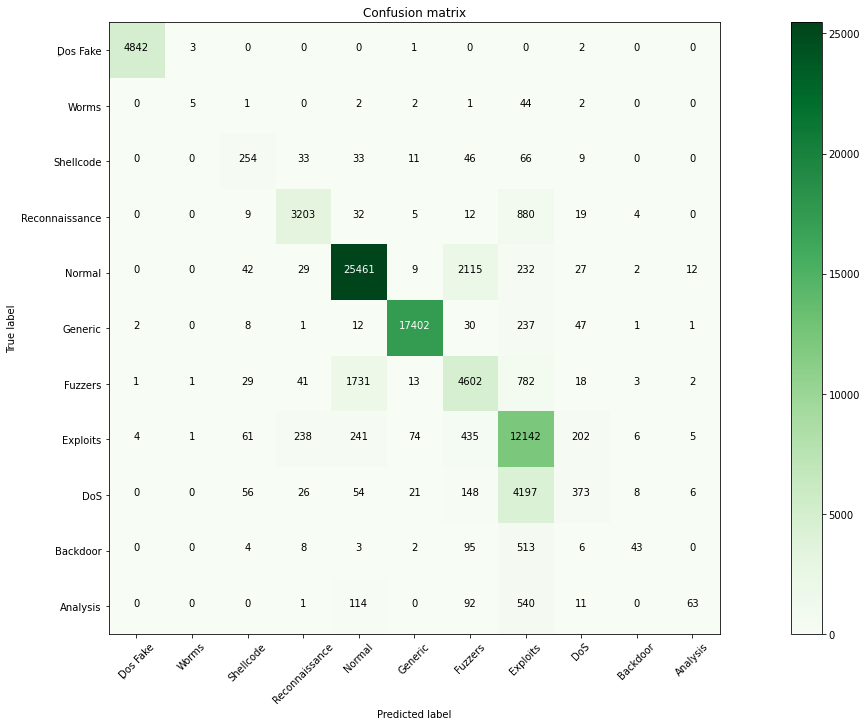

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[10,9,8,7,6,5,4,3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['ِDos Fake','Worms','Shellcode','Reconnaissance','Normal','Generic','Fuzzers','Exploits','DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')

In [16]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.71      0.08      0.14       821
           1       0.64      0.06      0.12       674
           2       0.52      0.08      0.13      4889
           3       0.62      0.91      0.73     13409
           4       0.61      0.64      0.62      7223
           5       0.99      0.98      0.99     17741
           6       0.92      0.91      0.92     27929
           7       0.89      0.77      0.83      4164
           8       0.55      0.56      0.55       452
           9       0.50      0.09      0.15        57
          10       1.00      1.00      1.00      4848

    accuracy                           0.83     82207
   macro avg       0.72      0.55      0.56     82207
weighted avg       0.83      0.83      0.81     82207



# **train label**

loss : 0.4043
loss : 0.1285
loss : 0.1218
loss : 0.1118
loss : 0.1009
loss : 0.1123
loss : 0.0982
loss : 0.0995
loss : 0.0998
loss : 0.0977
loss : 0.0934
Execution Time : 1132102.3750


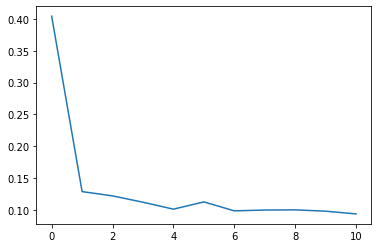

In [17]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_label_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer2.zero_grad()
        loss2 = loss_fn2(my_model_label(batch_x),batch_y)
        loss2.backward()
        optimizer2.step()

    if epoch % 50 == 0:
        print("loss : %.4f" % (loss2.item()))
        loss_plot.append(loss2.item())


end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print("Execution Time : %.4f" % (start.elapsed_time(end)))

plt.plot(range(len(loss_plot)),np.asarray(loss_plot))
plt.show()

# **test label**

In [18]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_label_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_label(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)    

print("acc : %.2f" % (100.*correct / len(test_label)),end="")
print("%")

acc : 94.27%


Confusion matrix, without normalization
[[51251  2969]
 [ 1744 26243]]


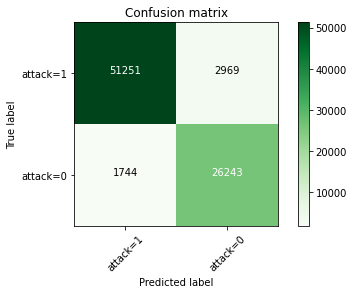

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['attack=1','attack=0'],normalize= False,  title='Confusion matrix')

In [20]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     27987
           1       0.97      0.95      0.96     54220

    accuracy                           0.94     82207
   macro avg       0.93      0.94      0.94     82207
weighted avg       0.94      0.94      0.94     82207

